<a href="https://colab.research.google.com/github/Nganle21/Big-Data-Dreamteam/blob/main/Ngan/Trained_notebooks/Lyrics_Gen_rock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


start fr here!

In [ ]:
text = open('/content/drive/MyDrive/Colab Notebooks/text_rock.txt', 'rb').read().decode(encoding='utf-8')

In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print('{} unique characters'.format(len(vocab)))
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

70 unique characters


In [ ]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [ ]:
# The maximum length sentence you want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

In [ ]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [ ]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [ ]:
# Batch size
BATCH_SIZE = 10

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset element_spec=(TensorSpec(shape=(10, 100), dtype=tf.int64, name=None), TensorSpec(shape=(10, 100), dtype=tf.int64, name=None))>

In [ ]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [ ]:
vocab_size

70

In [ ]:
model = build_model(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(10, 100, 70) # (batch_size, sequence_length, vocab_size)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (10, None, 256)           17920     
                                                                 
 gru (GRU)                   (10, None, 1024)          3938304   
                                                                 
 dense (Dense)               (10, None, 70)            71750     
                                                                 
Total params: 4,027,974
Trainable params: 4,027,974
Non-trainable params: 0
_________________________________________________________________


In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [ ]:
sampled_indices

array([51,  9, 26, 17, 53,  8, 10, 19, 62, 61, 23, 52, 52, 41,  4,  0, 61,
       16, 47, 56, 15,  4, 50,  5, 64, 12, 55, 46, 43, 13, 39, 22, 17,  2,
       26, 36,  0, 45, 25, 26, 50, 32, 43, 41, 62, 12, 11, 60,  8, 58, 39,
       49, 58, 57,  5,  5, 26, 37, 50, 34, 62, 53, 43, 29, 33, 42, 21, 67,
       35, 40,  0, 19, 26, 14, 45, 33, 10, 29, 54, 20, 45, 17, 10, 37, 31,
       38, 45,  6, 68, 22, 36, 24, 42, 38, 58, 15, 68, 57, 39, 59])

In [ ]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss = loss(target_example_batch, example_batch_predictions)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0,
    patience=1,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
my_callbacks = [es,checkpoint_callback]

In [ ]:

model.compile(optimizer='adam', loss=loss)

In [ ]:
EPOCHS=50

In [ ]:
history = model.fit(dataset, epochs=EPOCHS,callbacks=my_callbacks)

Epoch 1/50
2236/2236 [==============================] - 58s 25ms/step - loss: 1.6045
Epoch 2/50
2236/2236 [==============================] - 56s 25ms/step - loss: 1.2178
Epoch 3/50
2236/2236 [==============================] - 56s 25ms/step - loss: 1.0954
Epoch 4/50
2236/2236 [==============================] - 56s 24ms/step - loss: 1.0315
Epoch 5/50
2236/2236 [==============================] - 57s 25ms/step - loss: 1.0076
Epoch 6/50
2236/2236 [==============================] - 56s 25ms/step - loss: 1.0119


In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt_6'

In [ ]:

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            17920     
                                                                 
 gru_1 (GRU)                 (1, None, 1024)           3938304   
                                                                 
 dense_1 (Dense)             (1, None, 70)             71750     
                                                                 
Total params: 4,027,974
Trainable params: 4,027,974
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def generate_text(model, start_string,t):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 500

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperature results in more predictable text.
    # Higher temperature results in more surprising text.
    # Experiment to find the best setting.
    temperature = t

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))


In [ ]:
print(generate_text(model, start_string=u"i just want",t=0.3))

i just want to go
the way that you look so sorry

the stars, the sand
where you gonna be the one that saves me  that time goes by so slowly
time goes bye
because it's all come to me
i won't come back to me
why don't you come back to me
why don't you come back to me

i was a cherry pie
love has been homes


i ain't got nothing anymore

i can't stop lovin' you with you
i wanna be a good time, honey
no need to apply no pressure
we're just having a good time, honey
no need to apply no pres


In [ ]:
from keras.models import load_model
#To be used later; I am saving the model 
model.save("/content/drive/MyDrive/Colab Notebooks/rock_model.h5")

In [ ]:
from tensorflow import keras
a = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/rock_model.h5")

[Text(0.5, 0, 'Epochs')]

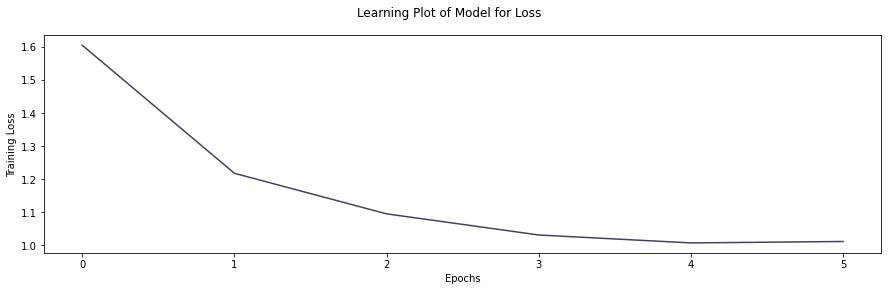

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
history_df = pd.DataFrame(history.history)
#Plotting the learnings 

fig = plt.figure(figsize=(15,4))
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")